This is where I'll be testing out code for digit recognition using scikit-learn and OpenCV. I find that collecting my though process and ideas in a notebook is both helpful for me to organize my thoughts, and great for passing on the information to any other interested software developers.

First thing to do is to download the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) and get a few helper methods going to load, preprocess, and split the data in to training, validation, and test datasets. 

In [30]:
import gzip
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import sklearn

Loading 60000 28x28 images from file: train-images-idx3-ubyte.gz
Loading 60000 labels from file: train-labels-idx1-ubyte.gz
Loading 10000 28x28 images from file: t10k-images-idx3-ubyte.gz
Loading 10000 labels from file: t10k-labels-idx1-ubyte.gz
Label: 3


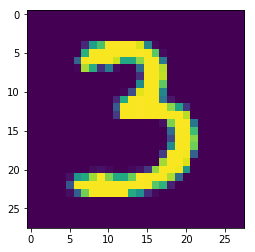

In [33]:



train_img_raw = "train-images-idx3-ubyte.gz"
train_label_raw = "train-labels-idx1-ubyte.gz"
test_img_raw = "t10k-images-idx3-ubyte.gz"
test_label_raw = "t10k-labels-idx1-ubyte.gz"

def read_int(fh,nbytes,order="big",signed=True):
    raw = fh.read(nbytes)
    return int.from_bytes(raw,byteorder=order,signed=signed)

def read_mnist_images(filename, normalize = False):
    fh = gzip.open(filename,"rb")
    fh.seek(4)
    
    nimages = read_int(fh,4)
    nrows = read_int(fh,4)
    ncols = read_int(fh,4)
    npixels = nrows * ncols
    
    print("Loading %d %dx%d images from file: %s" % 
          (nimages,nrows,ncols,os.path.basename(filename)))
    
    images = np.empty((nimages,nrows,ncols)) 
    for i in range(nimages):
        if normalize:
            images[i,:,:] = (np.fromstring(fh.read(npixels),dtype=np.uint8).reshape((28,28)) - 255/2) / 255
        else:
            images[i,:,:] = np.fromstring(fh.read(npixels),dtype=np.uint8).reshape((28,28))
    return images

def read_mnist_labels(filename):
    fh = gzip.open(filename,"rb")
    fh.seek(4)
    
    nlabels = read_int(fh,4)
    print("Loading %d labels from file: %s" % 
          (nlabels,os.path.basename(filename)))
    
    labels = np.empty((nlabels,))
    for i in range(nlabels):
        labels[i] = read_int(fh,1,signed=False)
    return labels
    

train_images = read_mnist_images(train_img_raw,normalize=True)
train_labels = read_mnist_labels(train_label_raw)
test_images = read_mnist_images(test_img_raw,normalize=True)
test_labels = read_mnist_labels(test_label_raw)
i = np.random.randint(0,len(images))
print("Label: %d" % (labels[i]))
plt.imshow(images[i])
plt.show()

My God... it worked! Now we have the MNIST data loaded as numpy arrays, let's do a little preprocessing and then write it out as a pickle file so we don't have to deal with that crap again!

In [34]:
def shuffle_dataset(data,labels):
    indices = np.random.permutation(len(data))
    return data[indices],labels[indices]

def make_validation_set(data,labels,nsamples=10000):
    new_data = data[:nsamples]
    new_labels = labels[:nsamples]
    valid_data = data[-nsamples:]
    valid_labels = labels[-nsamples:]
    return new_data,new_labels,valid_data,valid_labels

def write_pickled_data(tr_img,
                       tr_label,
                       val_img,
                       val_label,
                       ts_img,
                       ts_label,
                       output):
    data = {
        "train_images"  : tr_img,
        "train_labels" : tr_label,
        "valid_images"  : val_img,
        "valid_labels"  : val_label,
        "test_images"   : ts_img,
        "test_labels"   : ts_label
    }
    pickle.dump(data,open(output,"wb"))
    

new_train_img,new_train_label,valid_data,valid_label = make_validation_set(train_images,train_labels)
test_images,test_labels = shuffle_dataset(test_images,test_labels)
write_pickled_data(new_train_img,
                   new_train_label,
                   valid_data,
                   valid_label,
                   test_images,
                   test_labels,
                   "mnist_normalized.pickle")

Ok, now that we've got our dataset saved and ready to go, let's try to train a basic neural net to classify a digit using scikit-learn.

In [32]:
from sklearn.neural_network import MLPClassifier


# Start with some basic params, just specifying 2 hidden layers
# and to use the logistic function instead of step
params = {
    "hidden_layer_sizes" : (100,100),
    "activation" : "logistic"
}

data = pickle.load(open("mnist_normalized.pickle","rb"))

tr_img = data["train_images"]
tr_lbl = data["train_labels"]

v_img = data["valid_images"]
v_lbl = data["valid_labels"]

nn = MLPClassifier(**params)
nn.fit(tr_img.reshape((tr_img.shape[0],tr_img.shape[1]*tr_img.shape[2])),tr_lbl)
acc = nn.score(v_img.reshape((v_img.shape[0],v_img.shape[1]*v_img.shape[2])),v_lbl)
print("Accuracy on validation set: %f" % (acc))

Accuracy on validation set: 0.954400


It lives!!! And pretty good accuracy on the training set...although that'd still be about 1/20 digits being misclassified which doesn't sound too hot. Let's see if we can get better. Rather than just trying a bunch of parameters manually, let's whip something up for doing a naive exporation of the parameter space.

In [17]:
from itertools import product

def general_range(start,stop,step):
    val = start
    while val <=stop:
        yield val
        val += step
        
class BaseParam(object):
    def __init__(self,name):
        self.name = name

class ValueParam(BaseParam):  
    def __init__(self,name,start,stop,step):
        super().__init__(name)
        self.start = start
        self.stop = stop
        self.step = step
    
    def __iter__(self):
        return general_range(self.start,self.stop,self.step)

class StateParam(BaseParam):
    def __init__(self,name,states):
        super().__init__(name)
        self.states = states
        
    def __iter__(self):
        return iter(self.states)
    
class TupleParam(BaseParam):
    def __init__(self,name,sizes,values):
        super().__init__(name)
        self.sizes = sizes
        self.values = values
        
    @classmethod
    def from_lists(cls,name,sizes,values):
        return cls(name,sizes,values)

    @classmethod    
    def from_ranges(cls,
                    name,
                    size_start,
                    size_stop,
                    size_step,
                    value_start,
                    value_stop,
                    value_step):
        sizes = list(general_range(size_start,size_stop,size_step))
        values = list(general_range(size_start,size_stop,size_step))
        return cls(name,sizes,values)
   
    def generate_values(self):
        for size in self.sizes:
            for tuple_value in product(self.values,repeat=size):
                yield tuple_value
                
    def __iter__(self):
        return self.generate_values()
    
test_params = {
    "state_param":{
        "type" : "state",
        "states" : ["foo","bar","baz"]
    },
    "value_param":{
        "type" : "value",
        "start" : 0,
        "step" : 1,
        "stop" : 2
    },
    "tuple_param":{
        "type" : "tuple",
        "sizes" : [0,1,2],
        "values" : [5,7]
    },
    "tuple_param2":{
        "type" : "tuple",
        "size_start" : 1,
        "size_end" : 2,
        "size_step" : 1,
        "value_start" : -1,
        "value_stop" : 0,
        "value_step" : 1
    }
}

def generate_params(param_dict):
    params = []
    for pname in param_dict:
        param = param_dict[pname]
        ptype = param["type"]
        if ptype == "state":
            params.append(StateParam(pname,
                                     param["states"]))
        elif ptype == "value":
            params.append(ValueParam(pname,
                                     param["start"],
                                     param["stop"],
                                     param["step"]))
        elif ptype == "tuple":
            if "size_start" in param:
                params.append(TupleParam.from_ranges(pname,
                                         param["size_start"],
                                         param["size_end"],
                                         param["size_step"],
                                         param["value_start"],
                                         param["value_stop"],
                                         param["value_step"]))
            else:
                params.append(TupleParam.from_lists(pname,
                                         param["sizes"],
                                         param["values"]))
        else:
            print("Invalid parameter type: %s" % (param_dict))
    for i,param_set in enumerate(product(*params)):
        print(i,param_set)

generate_params(test_params)

0 ('foo', 0, (1,), ())
1 ('foo', 0, (1,), (5,))
2 ('foo', 0, (1,), (7,))
3 ('foo', 0, (1,), (5, 5))
4 ('foo', 0, (1,), (5, 7))
5 ('foo', 0, (1,), (7, 5))
6 ('foo', 0, (1,), (7, 7))
7 ('foo', 0, (2,), ())
8 ('foo', 0, (2,), (5,))
9 ('foo', 0, (2,), (7,))
10 ('foo', 0, (2,), (5, 5))
11 ('foo', 0, (2,), (5, 7))
12 ('foo', 0, (2,), (7, 5))
13 ('foo', 0, (2,), (7, 7))
14 ('foo', 0, (1, 1), ())
15 ('foo', 0, (1, 1), (5,))
16 ('foo', 0, (1, 1), (7,))
17 ('foo', 0, (1, 1), (5, 5))
18 ('foo', 0, (1, 1), (5, 7))
19 ('foo', 0, (1, 1), (7, 5))
20 ('foo', 0, (1, 1), (7, 7))
21 ('foo', 0, (1, 2), ())
22 ('foo', 0, (1, 2), (5,))
23 ('foo', 0, (1, 2), (7,))
24 ('foo', 0, (1, 2), (5, 5))
25 ('foo', 0, (1, 2), (5, 7))
26 ('foo', 0, (1, 2), (7, 5))
27 ('foo', 0, (1, 2), (7, 7))
28 ('foo', 0, (2, 1), ())
29 ('foo', 0, (2, 1), (5,))
30 ('foo', 0, (2, 1), (7,))
31 ('foo', 0, (2, 1), (5, 5))
32 ('foo', 0, (2, 1), (5, 7))
33 ('foo', 0, (2, 1), (7, 5))
34 ('foo', 0, (2, 1), (7, 7))
35 ('foo', 0, (2, 2), ())
36

Ok, now that we have the framework for testing a bunch of different parameter values, let's put it to good use.

In [ ]:
param_space = {
    "activation" : {
        "type" : "state",
        "states" : ["logistic"]
    },
    "alpha" : {
        "type" : "value",
        "start" : 0.0001,
        "stop" : 0.001,
        "step" : 0.0005
    },
    "hidden_layer_sizes" : {
        "type" : "tuple",
        "size_start" : 1,
        "size_stop" : 3,
        "size_step" : 1,
        "value_start" : 60,
        "value_stop" : 100,
        "value_step" : 20
    },
    "learning_rate_init" : {
        "type" : "value",
        "start" : 0.001,
        "stop" : 0.01,
        "step" : 0.005
    }
}

def train_model(params, train_data, train_labels):
    nn = MLPClassifier(**params)
    nn.fit(flatten_data(train_data), train_labels)
    return nn

def validate_model(model, valid_data, valid_labels):
    return model.score(flatten_data(valid_data), valid_labels)

def run_models(parameter_space,
               train_data,
               train_labels,
               valid_data,
               valid_labels,
               output_dir):
    best_i = None
    best_acc = 0
    best_params = None
    for i,params in enumerate(generate_params(parameter_space)):
        print(params)
        model = train_model(params, train_data, train_labels)
        valid_acc = validate_model(model, valid_data, valid_labels)

        stats = {}
        stats["params"] = model.get_params()
        stats["validation_accuracy"] = valid_acc

        json_out = os.path.join(output_dir, "model_%d_stats.json" % (i))
        json.dump(stats, open(json_out,"w"))

        model_out = os.path.join(output_dir, "model_%d.pickle" % (i))
        sklearn.externals.joblib.dump(model, open(model_out,"wb"))

        if valid_acc > best_acc:
            best_acc = valid_acc
            best_i = i
            best_params = params

    print("Model %d had highest validation accuracy: %f" % (best_i,best_acc))
    print("Parameters: %s" % (json.dumps(best_params,sort_keys=True,indent=4)))


run_models(param_space,tr_img,tr_lbl,v_img,v_lbl,"./models")

Running the above code gave model 39 as the best model, with 95.81% validation accuracy. The params for that model are pasted below:
```
{
    "power_t": 0.5,
    "batch_size": "auto",
    "activation": "logistic",
    "solver": "adam",
    "verbose": false,
    "random_state": null,
    "learning_rate_init": 0.006,
    "beta_2": 0.999,
    "warm_start": false,
    "hidden_layer_sizes": [
      100,
      60
    ],
    "beta_1": 0.9,
    "early_stopping": false,
    "validation_fraction": 0.1,
    "learning_rate": "constant",
    "momentum": 0.9,
    "shuffle": true,
    "nesterovs_momentum": true,
    "tol": 0.0001,
    "max_iter": 200,
    "epsilon": 1e-08,
    "alpha": 0.0006000000000000001
 }
```

Now let's work on extracting digits from a simple image to pass to our trained model. For starters, we'll do this in the following steps:
* Load the image and convert to grayscale
* Denoise by erosion and dilation followed by Gaussian blurring
* Threshold the image to binarize it
* Find the bounding box for all contours in the image
* For each box, scale up or down to a 28x28 image and pass to the network

This is a pretty naive approach, but it's a starting point. There are many improvments we could make, such as deskewing numbers to handle crooked handwriting, a better method for detecting digits (a real-life image will have a lot of contours that aren't our digits), or separating digits if their bounding boxes overlap. Here's our test image before and after denoising and binarization:

Ok, now that we have our preprocessed image ready to go, let's find all the contours and their bounding boxes:

(1096, 2462)
Greyscale test image:


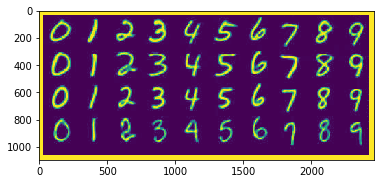

Denoised binarized image:


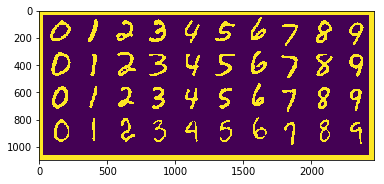

In [72]:
from IPython.display import Image,display
import cv2
import numpy as np
import matplotlib.pyplot as plt

test_img = "easy_digits.png"

def load_to_greyscale(image_fn):
    return cv2.imread(image_fn,flags=0)

def preprocess_image(img,ksize):
    opened = cv2.morphologyEx(img,cv2.MORPH_OPEN,np.ones((ksize,ksize)))
    smooth = cv2.GaussianBlur(opened,(ksize,ksize),0)
    return smooth

def binarize(img):
    thresh,binarized = cv2.threshold(img,
                                     0,
                                     255,
                                     cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binarized

grey = load_to_greyscale(test_img)
print(grey.shape)

print("Greyscale test image:")
plt.imshow(grey)
plt.show()

denoised = preprocess_image(grey,5)
binarized = binarize(denoised)

print("Denoised binarized image:")
plt.imshow(binarized)
plt.show()

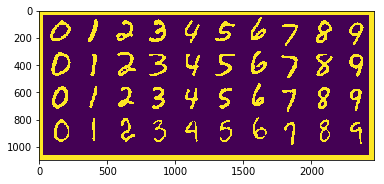

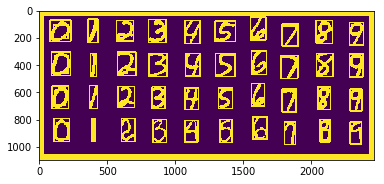

In [82]:
def get_contour_boxes(binarized):
    dest,contours,hierarchy = cv2.findContours(binarized.copy(),
                                               cv2.RETR_TREE,
                                               cv2.CHAIN_APPROX_NONE)
    return [cv2.boundingRect(contour) for contour in contours]

def extract_contour_subimgs(img,bounds,pad = 0.2):
    subimgs = []
    lower_pad = 1 + pad
    for x,y,w,h in bounds:
        xmin = max(0, x - int(w * pad))
        xmax = x + int(w * lower_pad)
        ymin = max(0, y - int(h * pad))
        ymax = y + int(h * lower_pad)
        
        subimgs.append(img[ymin:ymax,xmin:xmax])
    return subimgs

plt.imshow(binarized)
plt.show()

contour_boxes = get_contour_boxes(binarized)
print(len(contour_boxes))
annot = binarized.copy()
for i,(x,y,w,h) in enumerate(contour_boxes):
    cv2.rectangle(annot,(x,y),(x+w,y+h),(255,255,255),10)
plt.imshow(annot)
plt.show()

We've now extracted sub-images corresponding to the bounding rectangles around contours, but they're a bit noisy. In addition to the bounding rectangles we want, we also got ones corresponding to "internal" contours like the holes in 0, 6, 8, or 9, and a contour for the border of the image.

One strategy for dealing with these noisy boxes in this case could be to throw out bounding boxes whose area is significantly different from the median bounding box area. While this would apply in cases like a single person's handwriting (e.g. on a letter or handwritten note), this probably wouldn't be as effective if we wanted to classify all digits in a more complicated scene, like a picture of a city street.

15133.0
44


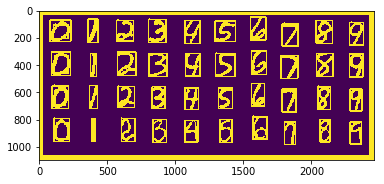

In [73]:
def median_area_filter(boxes,thresh = 3.8):
    #Get the median box area
    median_area = np.median([w * h for (x,y,w,h) in boxes])
    lb =  median_area / thresh
    ub =  median_area * thresh
    print(median_area)
    
    #Only keep sub images with area within an order of magnitude of the median
    return [(x,y,w,h) for (x,y,w,h) in boxes \
             if  w * h > lb \
             and w * h < ub]
     

filt_boxes = median_area_filter(contour_boxes)
print(len(filt_boxes))

filt_subimgs = extract_contour_subimgs(denoised,filt_boxes)

annot = binarized.copy()
for i,(x,y,w,h) in enumerate(filt_boxes):
    cv2.rectangle(annot,(x,y),(x+w,y+h),(255,255,255),10)
    cv2.putText(annot,str(i),(x,y),cv2.FONT_HERSHEY_PLAIN,1,(255,255,255))
plt.imshow(annot)
plt.show()

After playing with the thresholds a little bit, median area filtering seems to work pretty well on this dataset. Reducing the number of spurious boxes from 22 down to 4 (we'd expect 40 if everything was perfect). Unsurprisingly, the hardest ones to capture are the ones due to their narrowness...for this dataset maybe filtering on median height would be better, but median area seems likely to work more generally on other datasets. But let's try median height just to see

163.0
40


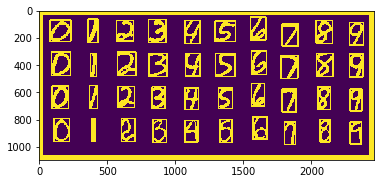

In [83]:
def median_height_filter(boxes,thresh = 1.2):
    #Get the median box height
    median_height = np.median([h for (x,y,w,h) in boxes])
    lb =  median_height / thresh
    ub =  median_height * thresh
    print(median_height)
    
    #Only keep sub images with area within an order of magnitude of the median
    return [(x,y,w,h) for (x,y,w,h) in boxes \
             if  h > lb \
             and h < ub]

filt_boxes = median_height_filter(contour_boxes)
print(len(filt_boxes))

filt_subimgs = extract_contour_subimgs(denoised,filt_boxes,0.5)

annot = binarized.copy()
for i,(x,y,w,h) in enumerate(filt_boxes):
    cv2.rectangle(annot,(x,y),(x+w,y+h),(255,255,255),10)
plt.imshow(annot)
plt.show()

It does seem like median height works much better here, and allows for a much tighter thresholding. One case where median area could work better is if the digits are skewed, but a deskewing step based off of moments of the contours could switch us back to a case where looking at height is more robust. Now the moment of truth...running our trained neural network on the sub-images we've extracted. 

[ 6.]


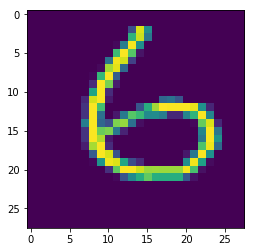

(28, 28)
[[ 0  0  0  0  0  0  0  4  0  5  1  0 23 66 43  9  7  7  0  0  0  0  0  0
   0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  5  1  0  0  0  7  2  0  4  1  0  0  0
   0  0  0  1]
 [ 0  0  0  0  0  0  0  1  3  2  0  0  3  7  6  1  0  4  4  1  0  0  0  0
   0  0  0  1]]
[0 0 0 0 0 0 0 4 0 5]
[ 9.]


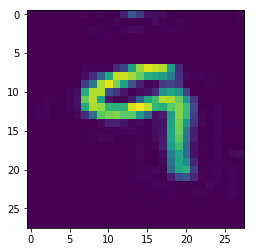

(28, 28)
[[  2   2   3   4   5   6   6  10   1  40 143 187 145  70   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   1   2   3   3   4   4   1   0   2   7   9   5   2   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   2   2   3   4   3   1   1   3   4   4   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[ 2  2  3  4  5  6  6 10  1 40]
[ 7.]


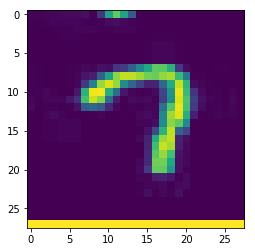

(28, 28)
[[ 0  0  0  0  0  0  0  0  0  0  4  4  0 61 48 39  1 11  1  9  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[0 0 0 0 0 0 0 0 0 0]
[ 4.]


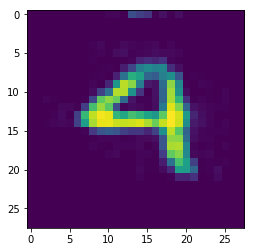

(28, 28)
[[ 0  2  2  3  4  1  1 15 26 26 20 16 17  0  4  0  2  1  0  0  0  0  0  0
   0  0  0  0]
 [ 0  2  2  3  4  0  0  0  1  1  6  9  3  4  0  0  0  2  0  0  0  0  0  0
   0  0  0  0]
 [ 0  2  2  3  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[ 0  2  2  3  4  1  1 15 26 26]
[ 5.]


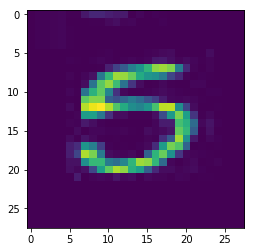

(28, 28)
[[ 0  1  1  0  4  0 21 28 61 66 58 30  7  5  5  3  0  2  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  1  0  6  1  7  2  0  0  0  0  5  4  4  0  6  5  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[ 0  1  1  0  4  0 21 28 61 66]
[ 3.]


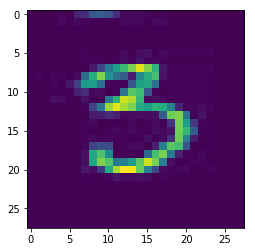

(28, 28)
[[  0   0   0   1   0  25  61 141 168 186 146 103  36  10   6  11   1   3
    1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   2   6   0   0   1   2   1   1   1   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[  0   0   0   1   0  25  61 141 168 186]
[ 9.]


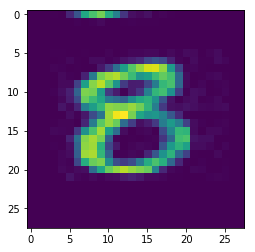

(28, 28)
[[  0   0   0   0   2   0  23  73 156 198 202 167 101  26   1   3   2   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   2   3   3   3  11   9   0   6   2   0   2   2   0   2   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[  0   0   0   0   2   0  23  73 156 198]
[ 0.]


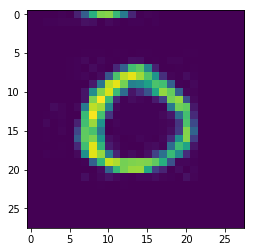

(28, 28)
[[189 187 186 183 180 167 122  98  83  47  32  23   6   0   0   0   0   4
   10  10   6   1   1   0   0   0   1   2]
 [  4   5   5   3   3   2   1   0   0   0   0   2   5   6   5   4   4   3
    1   1   2   4   3   2   1   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[189 187 186 183 180 167 122  98  83  47]
[ 4.]


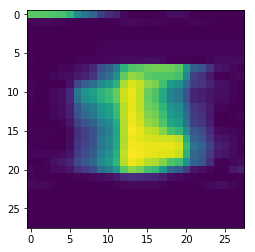

(28, 28)
[[ 0 14  2 15 37 80 78 63 17  4  2  0  0  0  0  0  0  2  2  2  2  2  1  0
   0  0  0  0]
 [ 5  3  0  6  9  3  5  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  1  0
   0  0  0  0]
 [ 0  2  0  1  4  1  0  0  1  1  1  0  0  0  0  0  0  1  1  1  1  1  0  0
   0  0  0  0]]
[ 0 14  2 15 37 80 78 63 17  4]
[ 2.]


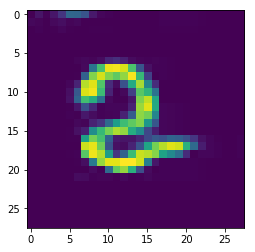

(28, 28)
[[ 0  0  0  0  0  0  1 17 62 80 67 68 60 37  5  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  1  9  6  1  0  2  1  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  1  5  2  0  3  4  7  6  3  3  0  0  0  0  0  0  0  0
   0  0  0  0]]
[ 0  0  0  0  0  0  1 17 62 80]
[ 6.]


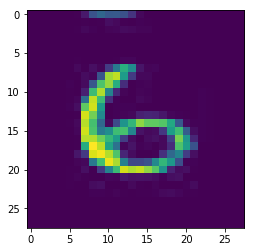

(28, 28)
[[  0   0   0   0   0   0   0   0   0   2   2   0  50 118 112  38   3   8
    1   4   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   3   5   1   1   1   5
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   1   1   4   3   0
    0   2   0   0   0   0   0   0   0   0]]
[0 0 0 0 0 0 0 0 0 2]
[ 7.]


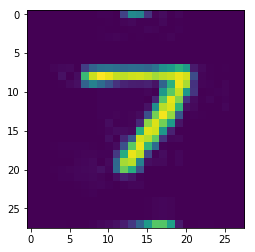

(28, 28)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 4 4 2 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 4 4 2 0 0 0 0 0 0 0 1 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 4 4 2 0 0 0 0 0 0 0 1 2]]
[0 0 0 0 0 0 0 0 0 0]
[ 9.]


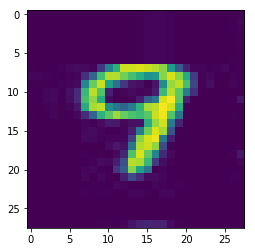

(28, 28)
[[0 0 0 2 2 4 4 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 4 4 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 4 4 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0 2 2 4 4 2 2 2]
[ 9.]


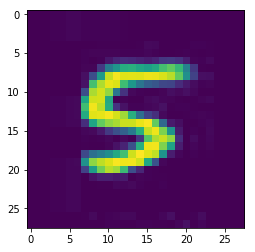

(28, 28)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 2 5 2 3 2 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 0 0 0 0 0]
[ 4.]


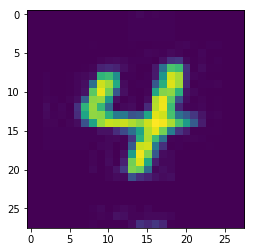

(28, 28)
[[  0   2   1   8   0  20  57  93 123 116  93  44  13   9   4   2   2   4
    8   4   3   2   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[  0   2   1   8   0  20  57  93 123 116]
[ 9.]


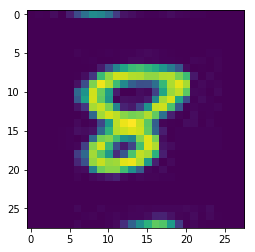

(28, 28)
[[ 2  2  4  2  8 58 84 72 52 30 13  2  1  2  3  1  2  1  5  4  0  0  0  0
   2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[ 2  2  4  2  8 58 84 72 52 30]
[ 3.]


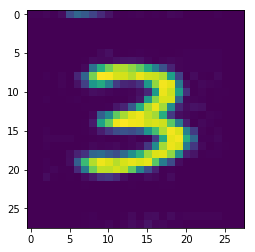

(28, 28)
[[ 0  0  0  0  8 17  2  4  2  1  7  9  0  6  0  4  2  3  2  2  2  2  1  0
   0  0  0  2]
 [ 0  0  0  0  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[ 0  0  0  0  8 17  2  4  2  1]
[ 2.]


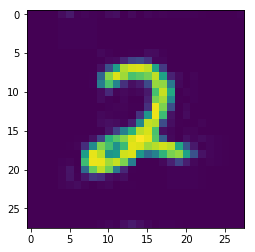

(28, 28)
[[  0   0   0   0   3   2   1  42 126 169 173 166 158 143  80  14   0  11
    5   5   7   0   1   0   0   0   0   0]
 [  0   0   0   0   3   6   1   3   0   0   2   4   1   2   2   2   1   6
    0   4   1   1   4   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   4   3   0   0   0   0   0   0]]
[  0   0   0   0   3   2   1  42 126 169]
[ 9.]


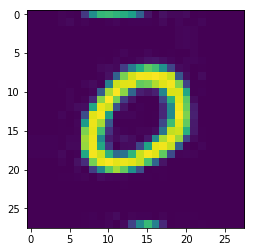

(28, 28)
[[  0   0   1   4   6   2   0   6  54 140 192 248 248 214 152  98   6   1
    1   1   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3   1  17  47  46  82  84  58  12  25   4   4
    3   0   5   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[  0   0   1   4   6   2   0   6  54 140]
[ 1.]


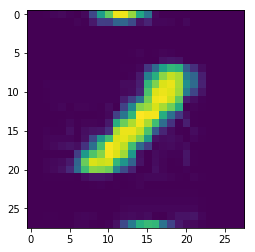

(28, 28)
[[  0   0   0   0   0   0   6 134 225 249 253 244 228 207 170 130  56  12
    2   2   2   2   2   2   2   0   0   0]
 [  0   0   0   0   0   0   0   6  12  15  20  17  14  25   3   1   7   2
    1   2   2   2   2   2   2   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   6   1   0   6  11   6   8  10
    6   2   2   2   2   2   2   0   0   0]]
[  0   0   0   0   0   0   6 134 225 249]
[ 6.]


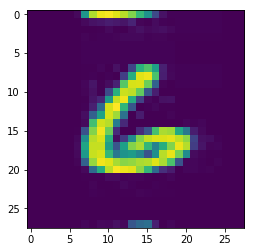

(28, 28)
[[  0   0   0   0   0   3   3   1  10  30 134 194  57   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3   4   5  14  59  61   6   2   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3   3   0   1   0   4   0   8   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[ 0  0  0  0  0  3  3  1 10 30]
[ 7.]


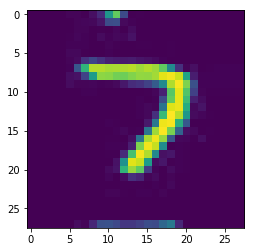

(28, 28)
[[  0   0   0   0   0   0   0   0   7  13  64 175 232 145   4   7   0   9
    4   0   0   0   0   0   0   0   0 166]
 [  0   0   2   2   2   2   2   2   1   3  41 113 100  15   2   2   2   2
    2   0   0   0   0   0   0   0   0 167]
 [  0   0   2   2   2   2   2   2   2   5   1   8   7   2   2   2   2   2
    2   0   0   0   0   0   0   0   0 166]]
[ 0  0  0  0  0  0  0  0  7 13]
[ 9.]


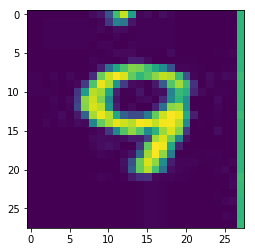

(28, 28)
[[  0   0   0   2   3   0   0  61 122 177 161 100  44   2   1   1   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   2   1   2   0   0   1   3   0   2   0   2   0   0
    0   0   0   0   1   1   1   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   2   2   2   2   0   0]]
[  0   0   0   2   3   0   0  61 122 177]
[ 8.]


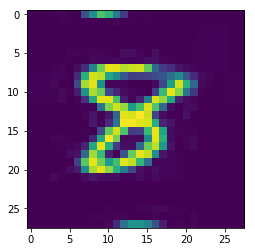

(28, 28)
[[0 0 0 0 0 2 1 0 7 0 0 2 1 0 3 1 1 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 2 1 0 7 0]
[ 9.]


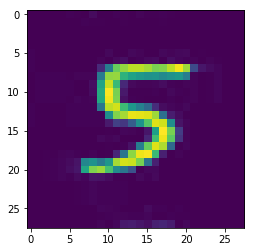

(28, 28)
[[  0   0   2   2   2   2   2   0   5   3  75 123 139  48   7   9  10   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   4   5   5   2   0   0   2   0   1
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   4   5   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
[0 0 2 2 2 2 2 0 5 3]
[ 4.]


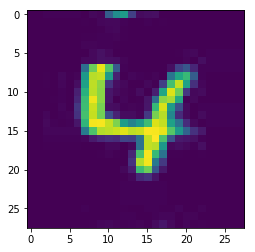

(28, 28)
[[ 0  0  1  2  3  4  0  0  0  7  0  0  5  0 11  0  0  0  1  2  2  2  2  0
   0  0  0  0]
 [ 0  0  0  1  2  2  0  2  0  3  1  0  0  0  2  2  0  3  1  1  1  1  1  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[0 0 1 2 3 4 0 0 0 7]
[ 3.]


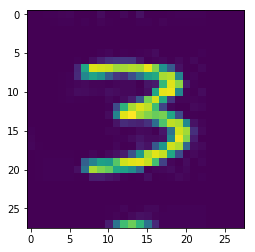

(28, 28)
[[ 1  0  6  6  0  1  2  6  3  1  6  8 10  2  0  0  0  0  0  2  5 10  7  0
   0  0  0  0]
 [ 1  0  0  0  0  0  0  2  1  0  4  4  3  0  0  1  3  4  0  0  0  0  0  1
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[1 0 6 6 0 1 2 6 3 1]
[ 7.]


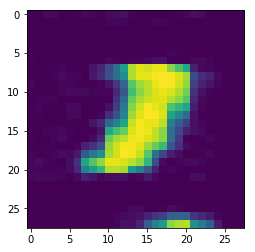

(28, 28)
[[ 0  0  0  0  0  2  0  7 51 17 10  2 12  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  2]
 [ 0  0  0  0  0  1  2 11  9  1  0  2  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  2]
 [ 0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
[ 0  0  0  0  0  2  0  7 51 17]
[ 2.]


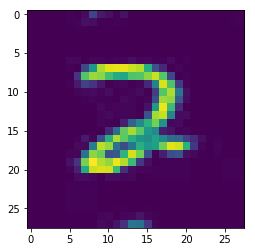

(28, 28)
[[255   2   2   2   2   6   2  11  51  95  90  39  12   6   0   4   3   0
    0   0   0   0   0   0   0   0   0   0]
 [255   2   2   2   2   6   5   1   2   3   1   5   1   4   1   0   1   0
    0   0   0   0   0   0   0   0   0   0]
 [255   0   0   0   0   1   0   1   0   1   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0]]
[255   2   2   2   2   6   2  11  51  95]
[ 7.]


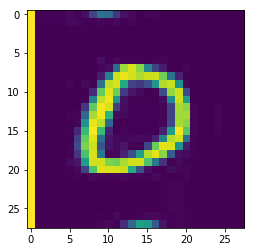

(28, 28)
[[ 0  0  1  3  0  1 15 40 74 69 72 58 53 13  1  5  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  3  2  0  0  5  6  0  3  4  0  6  5  0  2  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  3  1  1  2  0  2  0  3  1  0  0  0  1  0  1  0  0  0  0  0  0  0
   0  0  0  0]]
[ 0  0  1  3  0  1 15 40 74 69]
[ 6.]


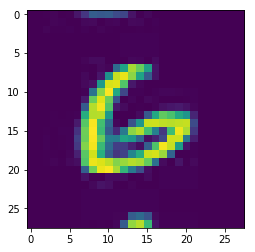

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [  5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   8   7
    5   5   5   5   5   5   5   5   5   5]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   3   0
    0   0   0   0   0   0   0   0   0   0]]
[255 255 255 255 255 255 255 255 255 255]
[ 7.]


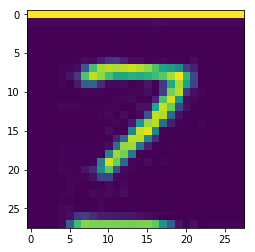

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [  2   2   2   2   2   2   2   2   4   2   2   6   6   8   6   4   2   5
    7   4   4   4   4   4   2   2  37 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 7.]


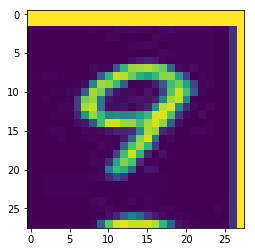

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 6.]


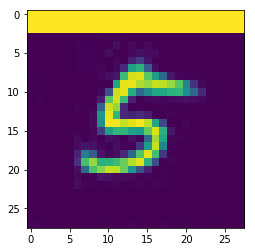

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 7.]


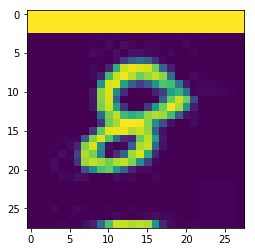

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 4.]


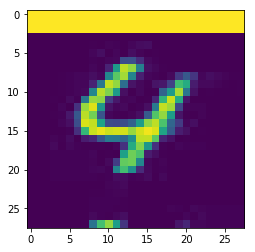

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 2.]


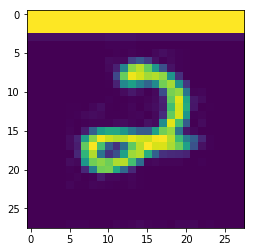

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 7.]


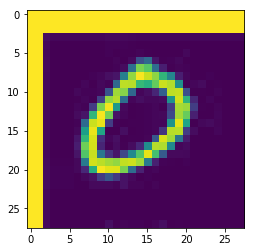

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 7.]


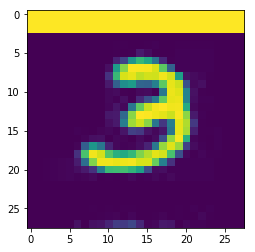

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 1.]


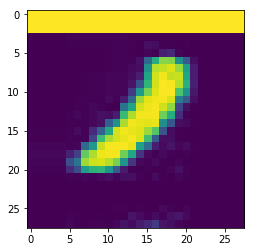

(28, 28)
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255]]
[255 255 255 255 255 255 255 255 255 255]
[ 6.]


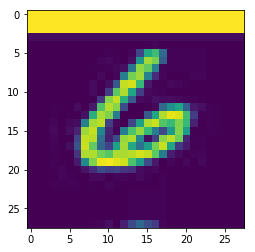

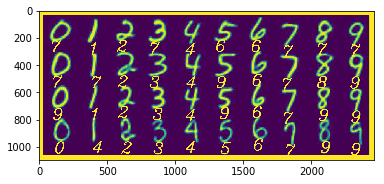

In [85]:
def normalize_image(img,pixel_depth = 255):
    return (img - (pixel_depth / 2)) / pixel_depth

def cleanup(img,ksize):
    erode = cv2.erode(img,np.ones((ksize,ksize)),iterations=5)
    #binarize = cv2.adaptiveThreshold(erode,)
    return erode

nn = sklearn.externals.joblib.load("models/model_39.pickle")
predict = nn.predict(v_img[20].reshape((1,-1)))
print(predict)
plt.imshow(v_img[20])
plt.show()

annot = denoised.copy()
for (x,y,w,h),subimg in zip(filt_boxes,filt_subimgs):
    resized = cv2.resize(subimg,(28,28))
    clean = cleanup(resized,1)
    smooth_res = normalize_image(clean)

    print(resized.shape)
    print(resized[0:3])
    print(resized.reshape((784,))[0:10])

    predicted = nn.predict(smooth_res.reshape(1,-1))
    print(predicted)
    plt.imshow(smooth_res)
    plt.show()
    cv2.putText(annot,str(int(predicted[0])),(x,y+int(h*1.5)),cv2.FONT_HERSHEY_SCRIPT_COMPLEX,4,(255,255,255),5,lineType=cv2.LINE_AA)
    
plt.imshow(annot)
plt.show()

Initial results are...not too good, lots of images being misclassified. One thing that's apparent from looking at the sub images compared to the training images is that the training images are more centered in the frame, so I went back and added some padding to the sub-image extraction. Also, I forgot to normalize our sub-images in the same way that we normalized the training images (subtracting pixel_depth/2 and dividing by pixel_depth, aka 255). Trying these ideas gave the following results:

* Raw sub-images: 9 /20 correct
* Centered with 0.2 padding: 20/40 correct
* Centered with 0.5 padding: 22/40 correct
* Centered with 0.2 padding, normalized: 23/40 correct
* Centered with 0.5 padding, normalized: 26/40 correct

One interesting fact is the way the errors shift with the different padding. With 0.5 padding, we see the most errors in calling 5's (as a 9 or 6) and 0's (as a 7 or a 9). With 0.2 padding, the most errors are in calling 9's (as 4s) and 1s (as 7s or 8s). Looking at the images, there are some non-zero pixels away from the digits, maybe some erosion and smoothing could help.

* Centered with 0.5 padding, normalized: 27/40 correct

Well clearly there's still more work to do, but for fun, let's see how we perform on a different images.